# Data Mining
This part includes all work on data mining. 
We will use three algorithms, including linear regression, random forest and gradient boosted tree classifier.

In [1]:
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('house_price_prediction_data_mining').getOrCreate()

from pyspark.ml.regression import LinearRegression

In [2]:
df = spark.read.csv('merged_df.csv',inferSchema=True,header=True)

In [3]:
print(df.count(),len(df.columns))

2590 19


In [4]:
# re-check any nulls before machine learning
from pyspark.sql.functions import isnan, when, count, col
print( df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show() )

+---+-------+-----------+---------+------------+----------+-----------+---------+--------+--------+------------+------------+----------+----------+----------+----------+-----------+---------+-------+
|_c0|LotArea|OverallQual|YearBuilt|YearRemodAdd|BsmtFinSF1|TotalBsmtSF|GrLivArea|FullBath|HalfBath|BedroomAbvGr|TotRmsAbvGrd|Fireplaces|GarageCars|GarageArea|WoodDeckSF|OpenPorchSF|SalePrice|TotalSF|
+---+-------+-----------+---------+------------+----------+-----------+---------+--------+--------+------------+------------+----------+----------+----------+----------+-----------+---------+-------+
|  0|      0|          0|        0|           0|         1|          1|        0|       0|       0|           0|           0|         0|         1|         1|         0|          0|        0|      0|
+---+-------+-----------+---------+------------+----------+-----------+---------+--------+--------+------------+------------+----------+----------+----------+----------+-----------+---------+-------+


In [5]:
# remove the nulls in the dataframe
for cols in df.columns:
    df = df.filter(df[cols].isNotNull())

In [6]:
print( df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show() )

+---+-------+-----------+---------+------------+----------+-----------+---------+--------+--------+------------+------------+----------+----------+----------+----------+-----------+---------+-------+
|_c0|LotArea|OverallQual|YearBuilt|YearRemodAdd|BsmtFinSF1|TotalBsmtSF|GrLivArea|FullBath|HalfBath|BedroomAbvGr|TotRmsAbvGrd|Fireplaces|GarageCars|GarageArea|WoodDeckSF|OpenPorchSF|SalePrice|TotalSF|
+---+-------+-----------+---------+------------+----------+-----------+---------+--------+--------+------------+------------+----------+----------+----------+----------+-----------+---------+-------+
|  0|      0|          0|        0|           0|         0|          0|        0|       0|       0|           0|           0|         0|         0|         0|         0|          0|        0|      0|
+---+-------+-----------+---------+------------+----------+-----------+---------+--------+--------+------------+------------+----------+----------+----------+----------+-----------+---------+-------+


In [7]:
print(df.count(),len(df.columns))

2588 19


In [8]:
# Print the schema of the DataFrame. You can see potential features as well as the predictor.
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- LotArea: integer (nullable = true)
 |-- OverallQual: integer (nullable = true)
 |-- YearBuilt: integer (nullable = true)
 |-- YearRemodAdd: integer (nullable = true)
 |-- BsmtFinSF1: double (nullable = true)
 |-- TotalBsmtSF: double (nullable = true)
 |-- GrLivArea: integer (nullable = true)
 |-- FullBath: integer (nullable = true)
 |-- HalfBath: integer (nullable = true)
 |-- BedroomAbvGr: integer (nullable = true)
 |-- TotRmsAbvGrd: integer (nullable = true)
 |-- Fireplaces: integer (nullable = true)
 |-- GarageCars: double (nullable = true)
 |-- GarageArea: double (nullable = true)
 |-- WoodDeckSF: integer (nullable = true)
 |-- OpenPorchSF: integer (nullable = true)
 |-- SalePrice: double (nullable = true)
 |-- TotalSF: integer (nullable = true)



In [9]:
# swapping SalePrice to the last column
column_names = ['_c0', 'LotArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'TotalBsmtSF', 'GrLivArea', 
                'FullBath', 'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 
                'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'TotalSF','SalePrice']
df = df.select(column_names)

In [10]:
print(df.columns)

['_c0', 'LotArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'TotalBsmtSF', 'GrLivArea', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'TotalSF', 'SalePrice']


# Linear regression

In [64]:
# Setting up a dataframe for machine learning
# Import VectorAssembler and Vectors
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
import time

In [66]:
# The input columns are the feature column names, and the output column is what you'd like the new column to be named. 
start = time.time()
assembler = VectorAssembler(
    inputCols= df.columns[1:18],
    outputCol="features")
output = assembler.transform(df)
# Let's select two columns (the feature and predictor).
final_data = output.select("features",'SalePrice')

# Let's do a randomised 70/30 split. 
train_data, test_data = final_data.randomSplit([0.7,0.3],722)

lr = LinearRegression(labelCol='SalePrice')
# Fit the model to the data.
lrModel = lr.fit(train_data)

elasped = time.time()-start

print("Training duration:", elasped, "seconds")

Training duration: 1.5456507205963135 seconds


In [15]:
# This is now in the appropriate format to be processed by Spark.
final_data.show()

+--------------------+------------------+
|            features|         SalePrice|
+--------------------+------------------+
|[8450.0,7.0,2003....| 5.319108142251936|
|[9600.0,6.0,1976....| 5.258879022172603|
|[11250.0,7.0,2001...| 5.349279470615652|
|[9550.0,7.0,1915....| 5.146131137770602|
|[14260.0,8.0,2000...| 5.397941745846491|
|[14115.0,5.0,1993...| 5.155339074478792|
|[10084.0,8.0,2004...| 5.487139790114889|
|[10382.0,7.0,1973...| 5.301032167130962|
|[6120.0,7.0,1931....| 5.113612494358711|
|[7420.0,5.0,1939....| 5.071885687752241|
|[11200.0,5.0,1965...|5.1122731220296656|
|[11924.0,9.0,2005...| 5.537820353896035|
|[12968.0,5.0,1962...| 5.158365508018679|
|[10652.0,7.0,2006...| 5.446383366046073|
|[10920.0,6.0,1960...| 5.195902418607315|
|[6120.0,7.0,1929....|5.1205772213030984|
|[11241.0,6.0,1970...| 5.173189183130559|
|[10791.0,4.0,1967...|  4.95424733490676|
|[13695.0,5.0,2004...|5.2013998557236985|
|[7560.0,5.0,1958....|  5.14301792466359|
+--------------------+------------

In [72]:
print(train_data.count(),len(train_data.columns))
print(test_data.count(),len(test_data.columns))

1763 2
825 2


In [73]:
# Let's see our training data.
train_data.describe().show()

# And our testing data.
test_data.describe().show()

+-------+-------------------+
|summary|          SalePrice|
+-------+-------------------+
|  count|               1763|
|   mean|  4.963131026659104|
| stddev|0.18849351496331268|
|    min|                  4|
|    max|                  5|
+-------+-------------------+

+-------+-------------------+
|summary|          SalePrice|
+-------+-------------------+
|  count|                825|
|   mean| 4.9406060606060604|
| stddev|0.23650390750301642|
|    min|                  4|
|    max|                  5|
+-------+-------------------+



In [22]:
# Print the coefficients and intercept for linear regression.
print("Coefficients: {} Intercept: {}".format(lrModel.coefficients,lrModel.intercept))

Coefficients: [6.426877368724252e-06,0.020371512832941488,0.0003324262022428119,0.00037883201157615405,1.7179881258895183e-05,2.940880116322147e-05,7.1115773772729735e-06,-0.0005872759023179024,-0.0015317517771235593,0.005480419596568958,0.004871528593897711,0.005637406402032128,0.006494288982737329,1.6089441510076242e-05,9.274480943532371e-06,-9.453180309557072e-06,5.0144001985448806e-05] Intercept: 3.4525462558993554


In [23]:
# Let's evaluate the model against the test data.
test_results = lrModel.evaluate(test_data)

In [24]:
# Interesting results! This shows the difference between the predicted value and the test data.
test_results.residuals.show()

# Let's get some evaluation metrics.
print("RSME: {}".format(test_results.rootMeanSquaredError))

+--------------------+
|           residuals|
+--------------------+
|-0.10919681592047326|
|-0.12242071763009665|
|0.005999238080447888|
| 0.09169714632036374|
| 0.15140869640170074|
|-0.15715562644064018|
|-0.10536002655945431|
| 0.17361044282661098|
| 0.13918352098404796|
| 0.08795480048215953|
|-0.08086350339996962|
| -0.3218477275187839|
|-0.13149622250666315|
|   0.146249803822311|
| 0.20791611887223027|
| -0.1456100204422741|
|-0.08524911992504247|
|  -0.156441999880637|
|-0.08308512232500576|
|-0.12371640735665945|
+--------------------+
only showing top 20 rows

RSME: 0.0932000659883984


In [25]:
# We can also get the R2 value. 
print("R2: {}".format(test_results.r2))

R2: 0.5110566383124188


In [26]:
final_data.describe().show()

+-------+------------------+
|summary|         SalePrice|
+-------+------------------+
|  count|              2588|
|   mean| 5.233371231384857|
| stddev|0.1291746816020055|
|    min|4.5428378707488655|
|    max| 5.872156855693515|
+-------+------------------+



In [67]:
from pyspark.sql.types import IntegerType
cols_to_transfer = df.columns
for x in cols_to_transfer:
    df = df.withColumn(x,df[x].cast(IntegerType()))

In [68]:
# The input columns are the feature column names, and the output column is what you'd like the new column to be named. 
assembler = VectorAssembler(
    inputCols= df.columns[1:18],
    outputCol="features")
output_tree = assembler.transform(df)

# Random forest 

In [70]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import GBTClassifier,RandomForestClassifier
from pyspark.ml import Pipeline

rfc_start = time.time()
indexer = StringIndexer(inputCol="SalePrice", outputCol="SalePriceIndex")
output_fixed = indexer.fit(output_tree).transform(output_tree)
final_data_tree = output_fixed.select("features",'SalePriceIndex')

# Split the training and testing set.
train_data_tree,test_data_tree = final_data_tree.randomSplit([0.7,0.3])

rfc = RandomForestClassifier(labelCol='SalePriceIndex',featuresCol='features')

rfc_model = rfc.fit(train_data_tree)
rfc_predictions = rfc_model.transform(test_data_tree)

rfc_elapsed = time.time() - rfc_start
print("traing time for rfc:", rfc_elapsed,"seconds")

traing time for rfc: 2.0121185779571533 seconds


# Gradient boosted tree classifier

In [71]:
gbt_start = time.time()
gbt = GBTClassifier(labelCol='SalePriceIndex',featuresCol='features')
gbt_model = gbt.fit(train_data_tree)

gbt_predictions = gbt_model.transform(test_data_tree)

gbt_elapsed = time.time()-gbt_start
print("traing time for gbt:", gbt_elapsed,"seconds")

traing time for gbt: 9.689993381500244 seconds


In [35]:
# Let's start off with binary classification.
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Note that the label column isn't named label, it's named PrivateIndex in this case.
my_binary_eval = BinaryClassificationEvaluator(labelCol = 'SalePriceIndex')

print("RFC")
print(my_binary_eval.evaluate(rfc_predictions))
my_binary_gbt_eval = BinaryClassificationEvaluator(labelCol='SalePriceIndex', rawPredictionCol='prediction')
print("GBT")
print(my_binary_gbt_eval.evaluate(gbt_predictions))

RFC
0.9495573159366261
GBT
0.6643056849953402


In [36]:
# Let's import the evaluator.
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# Select (prediction, true label) and compute test error. 
acc_evaluator = MulticlassClassificationEvaluator(labelCol="SalePriceIndex", predictionCol="prediction", metricName="accuracy")
rfc_acc = acc_evaluator.evaluate(rfc_predictions)
gbt_acc = acc_evaluator.evaluate(gbt_predictions)

print('A random forest ensemble has an accuracy of: {0:2.2f}%'.format(rfc_acc*100))
print('An ensemble using GBT has an accuracy of: {0:2.2f}%'.format(gbt_acc*100))

A random forest ensemble has an accuracy of: 96.75%
An ensemble using GBT has an accuracy of: 95.97%


# Search for patterns
algorithms:
linear regression,
random forest,
gradient boosted tree classifier

In [37]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols= df.columns[1:18],
    outputCol = 'features'
)

train_data_assembled = assembler.transform(df)

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def get_feature_importance_score(feature_importance, spark_df, feature_colname):
    """
    Extract feature importance scores and combine them with the feature name.
    """
    attributes_dict = spark_df.schema[feature_colname].metadata["ml_attr"]["attrs"]
    attributes_list = []
    
    for key in attributes_dict:
        attributes_list = attributes_list + attributes_dict[key]
    
    df_attributes = pd.DataFrame(attributes_list)
    df_attributes['score'] = df_attributes['idx'].apply(lambda x: feature_importance[x])
    df_attributes = df_attributes.sort_values(
        'score', 
        ascending = False
    ).drop(
        labels = 'idx', 
        axis = 1
    )
    
    return df_attributes

def plot_feature_importance_score(df, xlabel='feature importance'):
    x = np.array(df.name)
    y = np.array(df.score)
    plt.barh(x, y, height = 0.5,)
    plt.xlabel(xlabel)
    plt.ylabel('')
    plt.show()

In [76]:
logres_coef = get_feature_importance_score(
    feature_importance = lrModel.coefficients,
    spark_df = train_data_assembled,
    feature_colname = 'features'
)
logres_coef['score_abs'] = np.abs(logres_coef['score'])

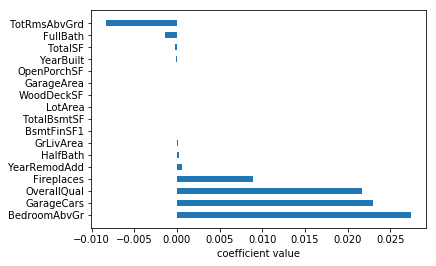

In [77]:
plot_feature_importance_score(logres_coef, xlabel = 'coefficient value')

In [78]:
rfc_feature = get_feature_importance_score(
    feature_importance = rfc_model.featureImportances,
    spark_df = train_data_assembled,
    feature_colname = 'features'
)

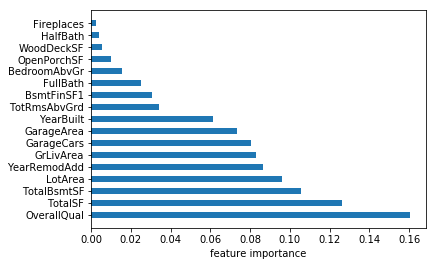

In [79]:
plot_feature_importance_score(rfc_feature)

In [80]:
gbt_feature = get_feature_importance_score(
    feature_importance = gbt_model.featureImportances,
    spark_df = train_data_assembled,
    feature_colname = 'features'
)

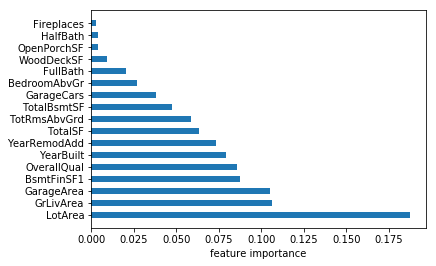

In [81]:
plot_feature_importance_score(gbt_feature)

In [61]:
TOP_N_FEATURES = 5
FEATURE_NAME_COL = 'name'

logres_top_features = logres_coef.sort_values(
    by = 'score_abs', 
    ascending = False
).head(TOP_N_FEATURES)[FEATURE_NAME_COL].values

df_top_features = pd.DataFrame(
    data = {
        'logistic_regression': logres_top_features,
        'random_forest': rfc_feature.head(TOP_N_FEATURES)[FEATURE_NAME_COL].values,
        'gbt': gbt_feature.head(TOP_N_FEATURES)[FEATURE_NAME_COL].values
    }
)

df_top_features

,gbt,logistic_regression,random_forest
0,LotArea,OverallQual,GrLivArea
1,OverallQual,GarageCars,LotArea
2,TotalBsmtSF,Fireplaces,TotalBsmtSF
3,GarageArea,BedroomAbvGr,OverallQual
4,GrLivArea,TotRmsAbvGrd,TotalSF


In [62]:
from itertools import chain

top_features = set(chain(*df_top_features.values))
top_features

{'BedroomAbvGr',
 'Fireplaces',
 'GarageArea',
 'GarageCars',
 'GrLivArea',
 'LotArea',
 'OverallQual',
 'TotRmsAbvGrd',
 'TotalBsmtSF',
 'TotalSF'}